In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12089
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|    47|[40, 88, -128, 88...|2002.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|    28|[120, 91, 120, 91...|2003.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|     0|[16, 90, 32, 91, ...|2004.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|     0|[-104, 90, -16, 9...|2005.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|     0|[-96, 91, -48, 91...|2006.0|BSBSSSBS|
+---------+--------+---------+-----------+-----------+------+-------------

# Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00088529')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00088529'
13 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     53.0| 29.9381| -82.1164|       PRCP|USC00088529|    11|[0, 0, 0, 0, 0, 0...|2000.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       PRCP|USC00088529|    45|[0, 126, 0, 126, ...|2001.0|BSBSSSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(13, 365)

In [3]:
stations = df.select('station', 'latitude', 'longitude').distinct()
stations
center_station = df.groupBy().avg('latitude', 'longitude').collect()
print "The center of the stations are", center_station

The center of the stations are [Row(avg(latitude)=28.446860501282007, avg(longitude)=-82.48461105136995)]


# Plots of mean and std of observations

In [4]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

In [5]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean'] / 10.0
    std=np.sqrt(STAT[m]['Var']) / 10.0
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    print mean.max()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

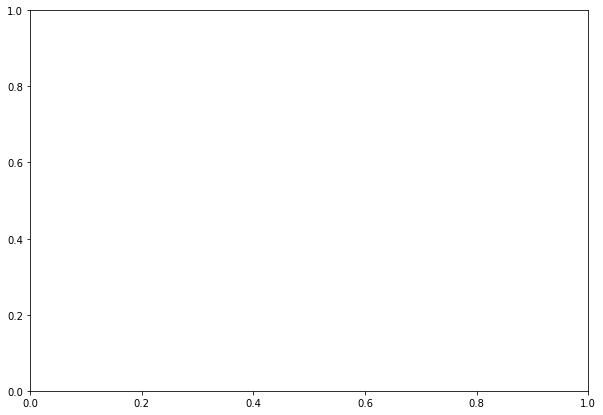

In [6]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()

In [7]:
def get_month_mean(m):
    month_data = np.zeros(12)
    mean = STAT[m]['Mean'] / 10
    days = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    start = 0
    for i in range(12):
        month_data[i] = np.mean(mean[start:start+days[i]])
        start += days[i]
    return month_data
    
PRCP_mean = get_month_mean("PRCP")
TMAX_mean = get_month_mean("TMAX")
TMIN_mean = get_month_mean("TMIN")

print PRCP_mean
print TMAX_mean
print TMIN_mean
    

[ 2.21125008  2.43399307  2.61165182  1.95932606  2.43177489  5.26564489
  6.12936765  6.37296757  4.58575563  2.04992103  1.37401787  1.86157535]
[ 21.21378053  22.3041269   24.97818082  27.78558216  30.77845873
  32.30910873  32.68696301  32.70865461  31.73392567  28.74593801
  24.95201516  21.90606054]
[  8.85752152   9.82377037  12.3321362   14.94773906  18.34581755
  21.38558439  22.40088689  22.53061592  21.58681739  17.50950167
  12.73181676   9.67263134]


22.717047619
32.936248237


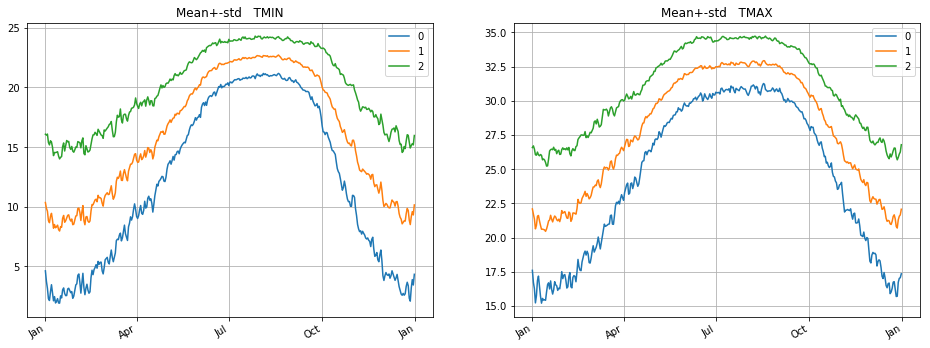

In [8]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

27.7279950341
8.07469657962


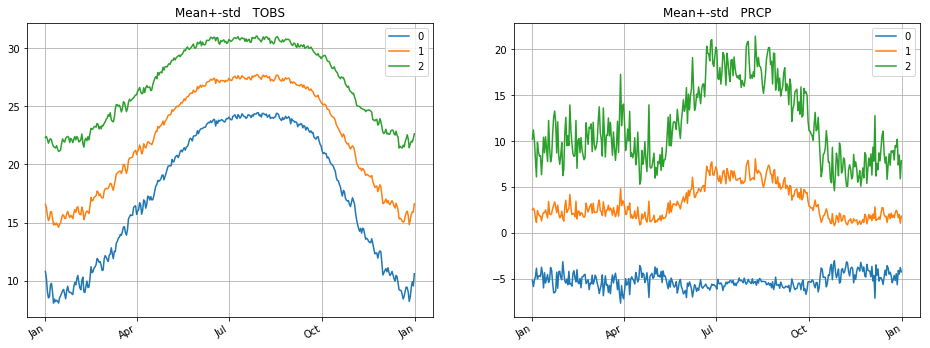

In [9]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

0.0119271445358
0.0253117206983


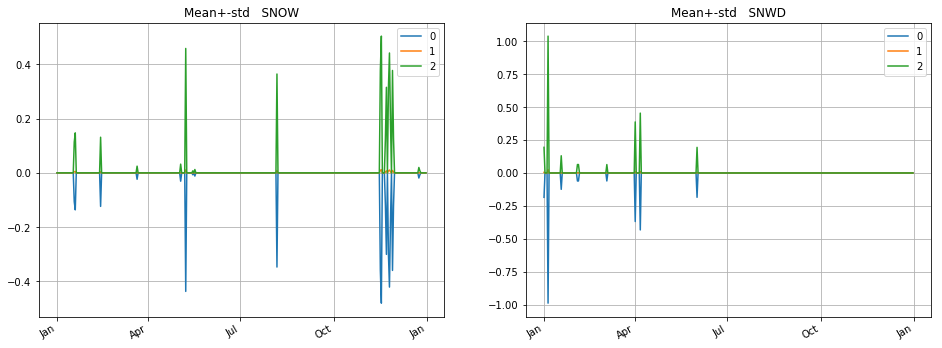

In [10]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

# PCA analysis

In [11]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

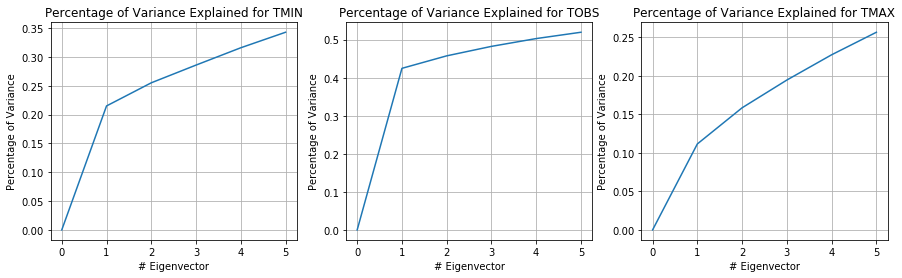

In [12]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

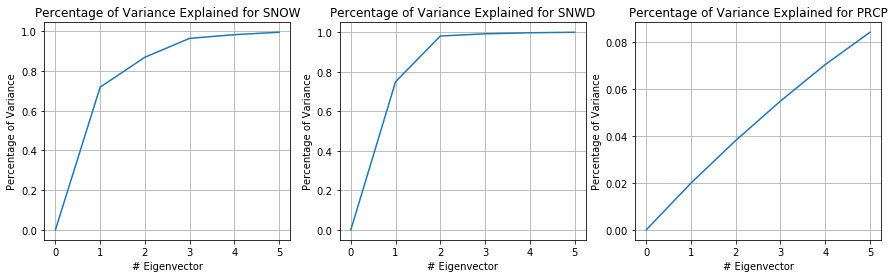

In [13]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

# Analyis of Daily Percipitation

In [14]:
m = 'TOBS'
sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
from Eigen_decomp import Eigen_decomp
from recon_plot import recon_plot
sqlContext = SQLContext(sc)

## Plot Reconstructions
Construct approximations of a time series using the mean and the  k
  top eigen-vectors First, we plot the mean and the top  k
  eigenvectors

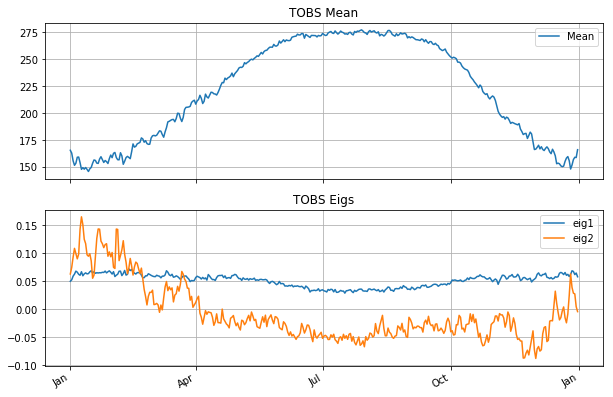

In [39]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,7));
k=2
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=np.copy(STAT[m]['Mean'])
# Mean /= 10
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

## plot the percent of residual variance on average

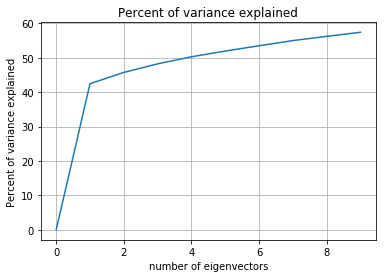

In [40]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

In [41]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|    48|[64, 76, 48, 85, ...|2002.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|    29|[0, 126, 112, 90,...|2003.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|     0|[-32, 84, -112, 8...|2004.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|     0|[-96, 86, -128, 8...|2005.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TOBS|USC00088529|     0|[-80, 88, -72, 89...|2006.0|BSBSSSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [42]:
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]

In [45]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)



In [46]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1).filter(df2.res_1<1).filter(df2.res_2<1)
print 'after filter',df3.count()


before filter 1651
after filter 1489


In [47]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10), coeff_num = 1):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='c' + str(coeff_num) + '=%3.2f,r1=%3.2f'\
                    %(row['coeff_' + str(coeff_num)],row['res_1'])
            plot_decomp(row,Mean,v,fig=fig,ax=axes[j],Title=_title,interactive=False)
    return None

In [50]:
df4=df3.sort(df3.coeff_1, ascending=False)
rows=df4.take(4)
df4.select('res_mean','res_1','res_2').show(4)

+--------------------+-------------------+-------------------+
|            res_mean|              res_1|              res_2|
+--------------------+-------------------+-------------------+
| 0.05523908883354076|0.25338529273303073| 0.2514751096551624|
| 0.05484483114545491|0.24736726092130776|0.24746982070012194|
| 0.05586707962514407|0.28957629779169436|0.23957606485224864|
|0.048115661566370316|0.25282798080695623|0.24627678257518454|
+--------------------+-------------------+-------------------+
only showing top 4 rows



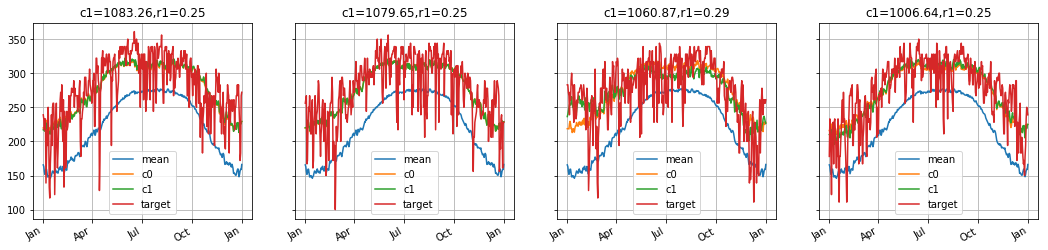

In [51]:
plot_recon_grid(rows, column_n=4, row_n=1, figsize=(18,4), coeff_num=1)

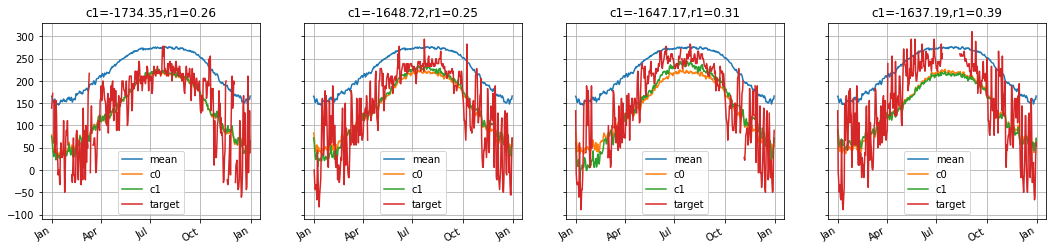

In [52]:
df5=df3.sort(df3.coeff_1, ascending=True)
rows=df5.take(4)
plot_recon_grid(rows, column_n=4, row_n=1, figsize=(18,4), coeff_num = 1)

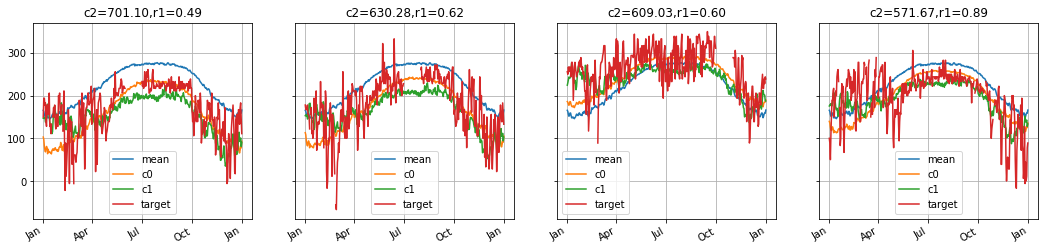

In [53]:
df6=df3.sort(df3.coeff_2, ascending=False)
rows=df6.take(4)
plot_recon_grid(rows, column_n=4, row_n=1, figsize=(18,4), coeff_num = 2)

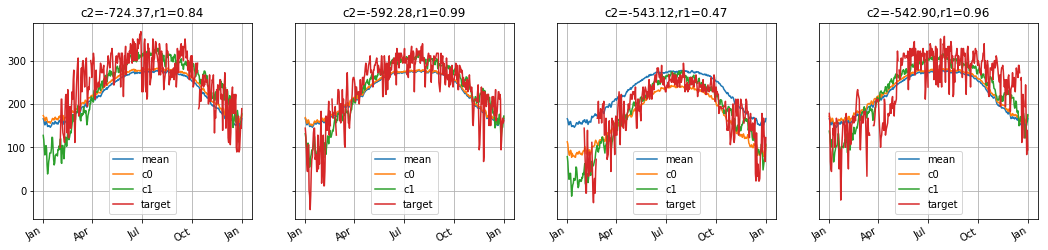

In [54]:
df7=df3.sort(df3.coeff_2, ascending=True)
rows=df7.take(4)
plot_recon_grid(rows, column_n=4, row_n=1, figsize=(18,4), coeff_num = 2)

In [55]:
df8=df3.sort(df3.coeff_3, ascending=False)
rows=df8.take(4)
plot_recon_grid(rows, column_n=4, row_n=1, figsize=(18,4), coeff_num = 3)

AttributeError: 'DataFrame' object has no attribute 'coeff_3'

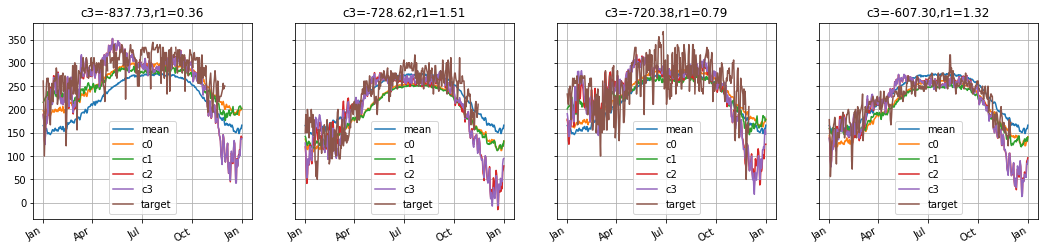

In [28]:
df9=df3.sort(df3.coeff_3, ascending=True)
rows=df9.take(4)
plot_recon_grid(rows, column_n=4, row_n=1, figsize=(18,4), coeff_num = 3)

## How well-explained are the vectors in this collection
To answer this question we extract all of the values of res_3 which is the residual variance after the Mean and the first two Eigen-vectors have been subtracted out. We rely here on the fact that df3 is already sorted according to res_3

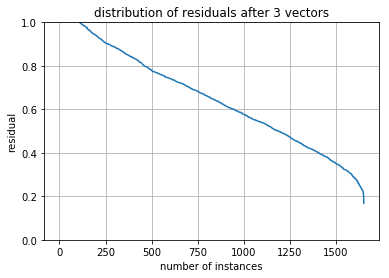

In [29]:
df3=df3.sort(df3.res_3,ascending=False)
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

## Analyis of Snow Depth

In [ ]:
m='SNWD'

In [ ]:
from pyspark import SparkContext
from pyspark.sql import *
from Eigen_decomp import Eigen_decomp
from recon_plot import recon_plot
sqlContext = SQLContext(sc)

In [ ]:
from pyspark import SparkContext
sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [ ]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

In [ ]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(15,9));
k=5
print STAT[m]['eigvec'].shape
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [ ]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

## plot the percent of residual variance on average

In [ ]:
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse coefficients

### Add to each row in the dataframe a residual values
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.
decompose(row) axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.

In [ ]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)

In [ ]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

In [ ]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

# def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
#     """plot a grid of reconstruction plots

#     :param rows: Data rows (as extracted from the measurements data-frame
#     :param column_n: number of columns
#     :param row_n:  number of rows
#     :param figsize: Size of figure
#     :returns: None
#     :rtype: 

#     """
#     fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
#     k=0
#     for i in range(row_n):
#         for j in range(column_n):
#             row=rows[k]
#             k+=1
#             #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
#             #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
#             #print i,j,_title,axes[i,j]
#             plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],interactive=False)
#     return None

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10), coeff_num = 1):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='c' + str(coeff_num) + '=%3.2f,r4=%3.2f'\
                    %(row['coeff_' + str(coeff_num)],row['res_4'])
            plot_decomp(row,Mean,v,fig=fig,ax=axes[j],Title=_title,interactive=False)
    return None

In [ ]:
df4=df3.sort(df2.coeff_1, ascending = True)
rows=df4.take(5)
df4.select('coeff_1','res_1').show(4)

In [ ]:
plot_recon_grid(rows, column_n=5, row_n=1, figsize=(18,3), coeff_num = 1)

In [ ]:
# df3.sort?

In [ ]:
df5=df3.sort(df3.coeff_1,ascending=False)
rows=df5.take(5)
df5.select('coeff_1','res_2').show(4)

In [ ]:
plot_recon_grid(rows, column_n=5, row_n=1, figsize=(18,3), coeff_num = 1)

In [ ]:
df6=df3.sort(df3.coeff_2,ascending=True)
rows=df6.take(5)
plot_recon_grid(rows, column_n=5, row_n=1, figsize=(18,3), coeff_num = 2)

In [ ]:
df7=df3.sort(df3.coeff_2,ascending=False)
rows=df7.take(5)
plot_recon_grid(rows, column_n=5, row_n=1, figsize=(18,3), coeff_num = 2)

In [ ]:
df8=df3.sort(df3.coeff_3,ascending=True)
rows=df8.take(5)
plot_recon_grid(rows, column_n=5, row_n=1, figsize=(18,3), coeff_num = 3)

In [ ]:
df9=df3.sort(df3.coeff_3,ascending=False)
rows=df9.take(5)
plot_recon_grid(rows, column_n=5, row_n=1, figsize=(18,3), coeff_num = 3)

In [ ]:
df10=df3.sort(df3.coeff_4,ascending=True)
rows=df10.take(5)
plot_recon_grid(rows, column_n=5, row_n=1, figsize=(18,3), coeff_num = 4)

In [ ]:
df11=df3.sort(df3.coeff_4,ascending=False)
rows=df11.take(5)
plot_recon_grid(rows, column_n=5, row_n=1, figsize=(18,3), coeff_num = 4)

In [ ]:
df5=df3.sort(df3.coeff_2,ascending=False)
rows=df5.take(12)
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())